In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test

In [3]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
# fix random seed for reproducibility
np.random.seed(42)

In [6]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [7]:
%%time
X_lt_FNML128, y_lt_FNML128, X_rt_FNML128, y_rt_FNML128, X_lb_FNML128, y_lb_FNML128, X_rb_FNML128, y_rb_FNML128, X_ct_FNML128, y_ct_FNML128 \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/France_New_ByMeaningLarge_128_3dim",
                                ["AllTransport", "Restaurant"])

Wall time: 45.3 s


In [8]:
# so, let's try another one - there will be neuron net for each part

In [9]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [10]:
### Xception, with retrain

def run_Xception_with_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = Xception(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = True
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=2, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 65538     
Total params: 20,927,018
Trainable params: 20,872,490
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 271s 91ms/step - loss: 1.0538 - acc: 0.5418 - val_loss: 0.6863 - val_acc: 0.5813
Epoch 2/300
2977/2977 [==============================] - 187s 63ms/

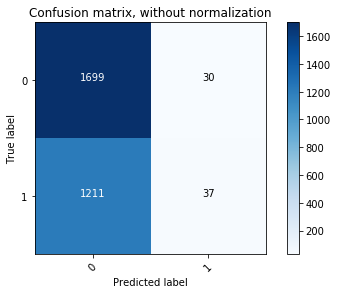

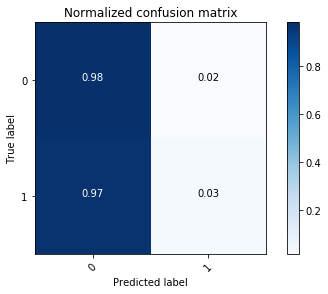

Confusion matrix, without normalization
[[188   5]
 [135   4]]
Normalized confusion matrix
[[0.97409326 0.02590674]
 [0.97122302 0.02877698]]


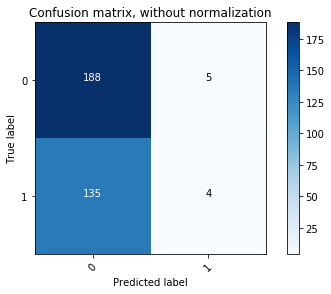

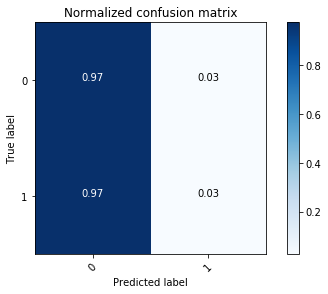

Wall time: 26min 48s


In [11]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_FNML128, y_ct_FNML128, num_categories=2)


model_ct, history_ct, test_scores_ct = run_Xception_with_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=2,
                                                                           patience=7)

In [12]:
print("center result accuracy:", test_scores_ct[1])

center result accuracy: 0.5783132530120482


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 65538     
Total params: 20,927,018
Trainable params: 20,872,490
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 206s 69ms/step - loss: 1.3453 - acc: 0.5233 - val_loss: 2.4341 - val_acc: 0.4578
Epoch 2/300
2977/2977 [==============================] - 188s 63ms/

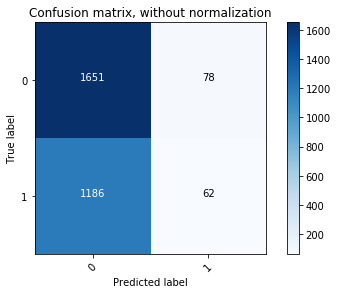

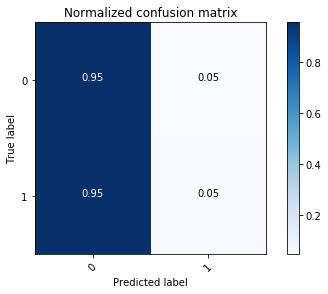

Confusion matrix, without normalization
[[189   4]
 [131   8]]
Normalized confusion matrix
[[0.97927461 0.02072539]
 [0.94244604 0.05755396]]


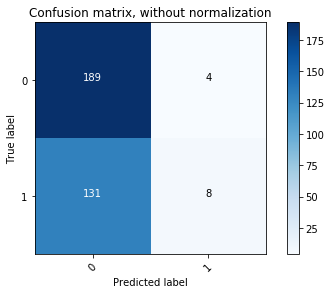

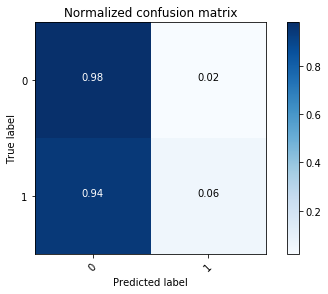

Wall time: 1h 23min 16s


In [13]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_FNML128, y_lt_FNML128, num_categories=2)


model_lt, history_lt, test_scores_lt = run_Xception_with_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=2,
                                                                           patience=7)

In [15]:
print("left_top result accuracy:", test_scores_lt[1])

left_top result accuracy: 0.5933734939759037


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 65538     
Total params: 20,927,018
Trainable params: 20,872,490
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 206s 69ms/step - loss: 1.2337 - acc: 0.5398 - val_loss: 3.9094 - val_acc: 0.5633
Epoch 2/300
2977/2977 [==============================] - 179s 60ms/

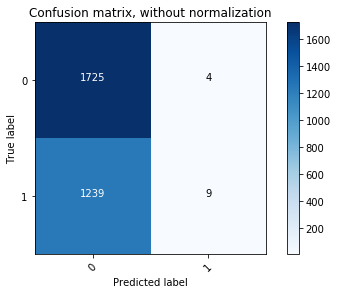

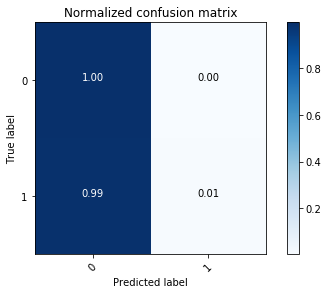

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


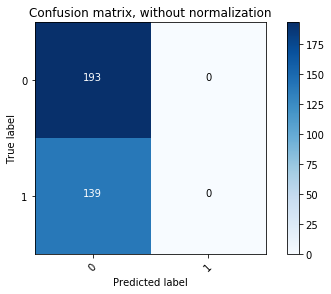

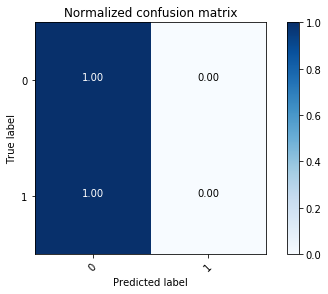

Wall time: 56min 29s


In [16]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_FNML128, y_rt_FNML128, num_categories=2)


model_rt, history_rt, test_scores_rt = run_Xception_with_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=2,
                                                                           patience=7)

In [17]:
print("right_top result accuracy:", test_scores_rt[1])

right_top result accuracy: 0.5813253012048193


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 65538     
Total params: 20,927,018
Trainable params: 20,872,490
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 206s 69ms/step - loss: 2.6649 - acc: 0.5472 - val_loss: 2.6129 - val_acc: 0.5813
Epoch 2/300
2977/2977 [==============================] - 181s 61ms/

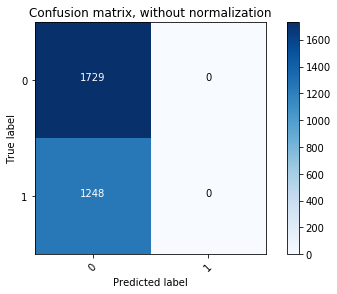

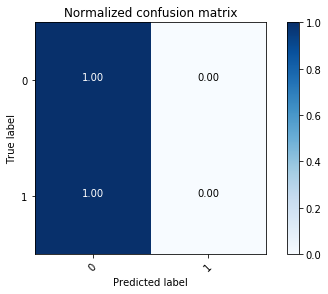

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


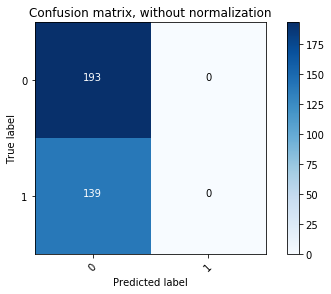

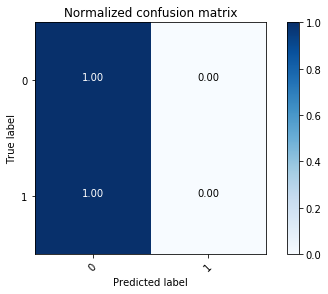

Wall time: 1h 8min 49s


In [18]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_FNML128, y_lb_FNML128, num_categories=2)


model_lb, history_lb, test_scores_lb = run_Xception_with_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=2,
                                                                           patience=7)

In [19]:
print("left_bottom result accuracy:", test_scores_lb[1])

left_bottom result accuracy: 0.5813253012048193


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 65538     
Total params: 20,927,018
Trainable params: 20,872,490
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 208s 70ms/step - loss: 1.2050 - acc: 0.5455 - val_loss: 3.2639 - val_acc: 0.5753
Epoch 2/300
2977/2977 [==============================] - 181s 61ms/

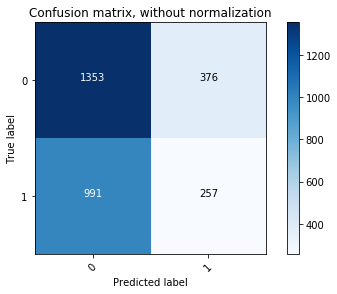

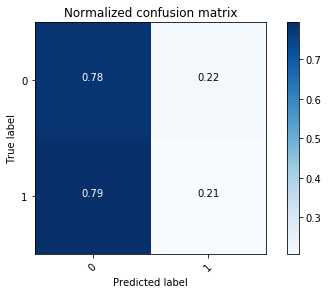

Confusion matrix, without normalization
[[171  22]
 [102  37]]
Normalized confusion matrix
[[0.88601036 0.11398964]
 [0.73381295 0.26618705]]


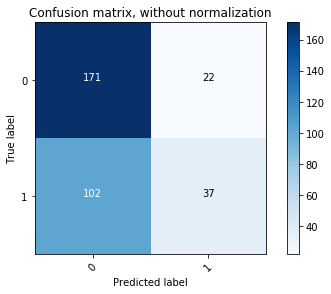

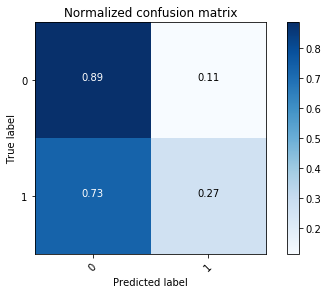

Wall time: 32min 50s


In [20]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_FNML128, y_rb_FNML128, num_categories=2)


model_rb, history_rb, test_scores_rb = run_Xception_with_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=2,
                                                                           patience=7)

In [21]:
print("right_bottom result accuracy:", test_scores_rb[1])

right_bottom result accuracy: 0.6265060242759176


## Validation accuracy results

In [22]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.5783
left_top result accuracy: 0.5934
right_top result accuracy: 0.5813
left_bottom result accuracy: 0.5813
right_bottom result accuracy: 0.6265


In [23]:
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_lt.predict(X_rt_train)
predict_result_rt_test = model_lt.predict(X_rt_test)

predict_result_lb_train = model_lt.predict(X_lb_train)
predict_result_lb_test = model_lt.predict(X_lb_test)

predict_result_rb_train = model_lt.predict(X_rb_train)
predict_result_rb_test = model_lt.predict(X_rb_test)

In [24]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(2977, 10)


In [25]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(332, 10)


In [26]:
# than write this arrays into file
file_path_un_train = "./un_train_France_ByMeaningLarge128.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./un_test_France_ByMeaningLarge128.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./y_train_France_ByMeaningLarge128.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./y_test_France_ByMeaningLarge128.npy"
np.save(file_path_y_test, y_ct_test)

In [27]:
#np.load(file_path_un_train)

test accuracy:  0.5753

Confusion matrix, without normalization
[[1341  388]
 [ 601  647]]
Normalized confusion matrix
[[0.77559283 0.22440717]
 [0.48157051 0.51842949]]


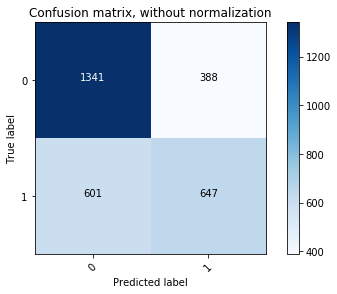

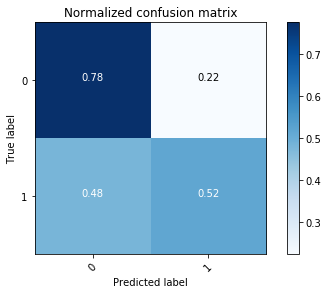

Confusion matrix, without normalization
[[131  62]
 [ 79  60]]
Normalized confusion matrix
[[0.67875648 0.32124352]
 [0.56834532 0.43165468]]


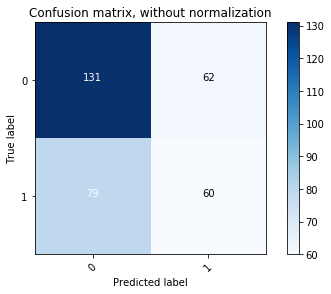

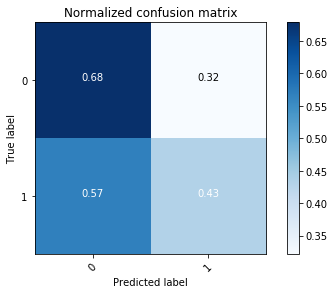

In [28]:
#let's try KNN first
categories_count = 2

knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn_uniform_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_uniform_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_uniform_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_uniform_15)
print("")

print_confusion_matrix(knn_uniform_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [29]:
knn_uniform_15_predict_train = knn_uniform_15.predict(predict_un_train)
knn_uniform_15_predict_test = knn_uniform_15.predict(predict_un_test)

file_path_knn_uniform_15_train = "./knn_uniform_15_train_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_knn_uniform_15_train, knn_uniform_15_predict_train)

file_path_knn_uniform_15_test = "./knn_uniform_15_test_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_knn_uniform_15_test, knn_uniform_15_predict_test)


test accuracy:  0.5813

Confusion matrix, without normalization
[[1702   27]
 [   0 1248]]
Normalized confusion matrix
[[0.98438404 0.01561596]
 [0.         1.        ]]


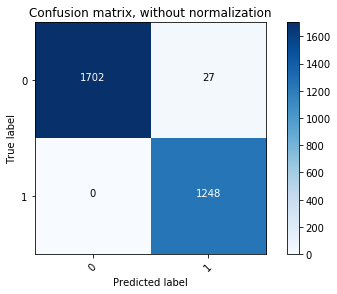

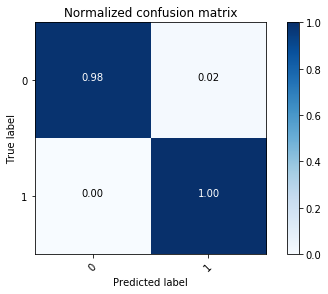

Confusion matrix, without normalization
[[127  66]
 [ 73  66]]
Normalized confusion matrix
[[0.65803109 0.34196891]
 [0.52517986 0.47482014]]


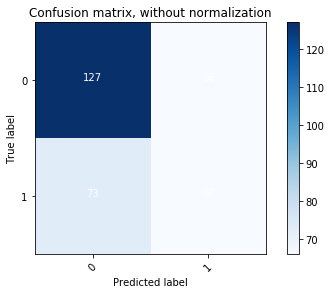

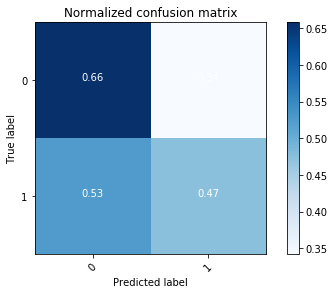

In [30]:
#let's try KNN with another weights
categories_count = 2

knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [31]:
knn_distance_15_predict_train = knn_distance_15.predict(predict_un_train)
knn_distance_15_predict_test = knn_distance_15.predict(predict_un_test)

file_path_knn_distance_15_train = "./knn_distance_15_train_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_knn_distance_15_train, knn_distance_15_predict_train)

file_path_knn_distance_15_test = "./knn_distance_15_test_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_knn_distance_15_test, knn_distance_15_predict_test)


In [32]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.5813



In [33]:
svm_predict_train = svm.predict(predict_un_train)
svm_predict_test = svm.predict(predict_un_test)

file_path_svm_train = "./svm_train_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_svm_train, svm_predict_train)

file_path_svm_test = "./svm_test_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_svm_test, svm_predict_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5632      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 137,474
Trainable params: 137,474
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 21s 7ms/step - loss: 0.7251

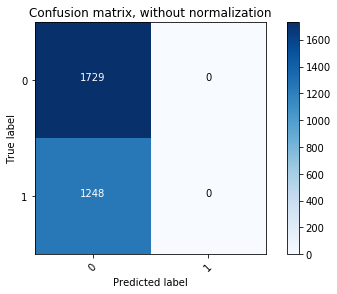

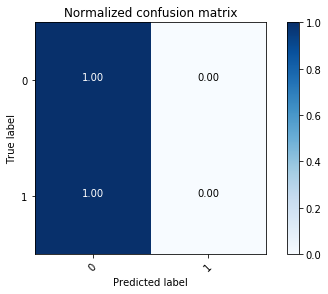

Confusion matrix, without normalization
[[193   0]
 [139   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


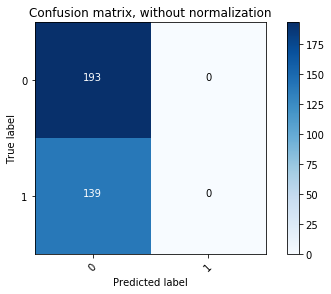

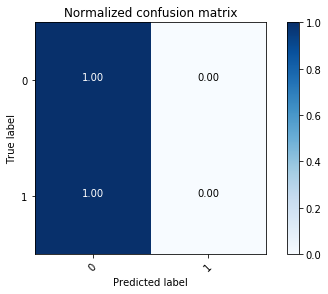

Wall time: 3min 5s


In [34]:
%%time
# and also multilayer neuron net
categories_count = 2

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=3, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

In [35]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.5813
best test accuracy: 0.5994


In [36]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./meta_net_train_Xception_France_ByMeaningLarge128.npy"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./meta_net_test_Xception_ByMeaningLarge128.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)
